In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as stats
import random
import os
import math
import networkx as nx
from EmbDI.graph import Graph
from EmbDI.utils import *

In [41]:
import csv

In [74]:
class StudyUnit:
    def __init__(self, dataset_name, prefixes=['3#__tn', '3$__tt','5$__idx', '1$__cid']):
        path_df = str('pipeline/datasets/{}/{}-master.csv'.format(dataset_name, dataset_name))
        self.df = pd.read_csv(path_df, dtype=str)

        dataset_info = 'pipeline/info/info-{}.txt'.format(dataset_name)
        with open(dataset_info, 'r') as fp:
            n_items = {}
            for idx, line in enumerate(fp):
                k, v = line.split(',')
                n_items[idx] = int(v)

        match_file = 'pipeline/matches/matches-{}.txt'.format(dataset_name)

        with open(match_file, 'r') as fp:
            for ix, line in enumerate(fp):
                pass
            self.matching_lines = ix
        self.df1 = self.df[:n_items[0]]
        self.df2 = self.df[n_items[0]:]
        counts = Counter(self.df.values.ravel())
        if np.nan in counts:
            counts.pop(np.nan)

        self.uniq_df1 = set(self.df1.values.ravel().tolist())
        self.uniq_df2 = set(self.df2.values.ravel().tolist())
        self.uniq_complete = self.uniq_df1.union(self.uniq_df2)
        self.intersection = self.uniq_df1.intersection(self.uniq_df2)
        self.ov_col = [_ for _ in self.df1.columns if _ in self.df2.columns]
        
        self.build_graph(dataset_name)
        
#         with open(edgelist_file, 'r') as fp:
#             for idx, line in enumerate(fp):
#                 split = line.split(',')
#                 if len(split) < 2:
#                     continue
#                 n1, n2 = split[:2]
#                 self.graph.add_edge(n1,n2)

    def build_graph(self, dataset_name):
        edgelist_file = 'pipeline/edgelists/{}-edgelist.txt'.format(dataset_name)

        prefixes, edgelist = read_edgelist(edgelist_file)
        
        g = Graph(edgelist, prefixes=prefixes, flatten=['tt'])

        self.nxg = g.convert_to_nx()

    
    def edges_by_node(self):
        ebn = {}
        for node in self.nxg.nodes():
            if node.startswith('idx__') or node.startswith('cid__'):
                continue
            ebn[node] = len(self.nxg.edges(node))
        return ebn
        
    def get_basic_info(self):
        info = [
            len(self.df),
            len(self.df.columns),
            self.matching_lines,
            len(self.ov_col),
            len(self.intersection),
            100 * (len(self.intersection) / len(self.uniq_complete))
        ]
        return info

    def get_graph_info(self):
        ebn = self.edges_by_node()
        v1 = sorted([ebn[_] for _ in ebn], reverse=True)
        v2 = [0]*1 + v1
        v1 = np.array(v1)
        v2 = np.array(v2)
        
        info = []
        

        info = []
        
        total_nodes = len(v1)
        avg = np.average(v1)
        sumdeg = np.sum(v1)
        maxdeg = max(v1)
        perc = np.percentile(v1, 99)
        aboveperc = v1[v1>perc]
        edgesaboveperc = sum(aboveperc)
        avg_deg_above_perc = np.average(aboveperc)
        
        info.append(total_nodes)
        info.append(avg)
        info.append(sumdeg)
        info.append(maxdeg)
        info.append(perc)
        info.append(len(aboveperc))
        info.append(edgesaboveperc)
        info.append(edgesaboveperc/sumdeg*100)
        info.append(avg_deg_above_perc)

        return info

    
    def print_basic_info(self):
        print('Overall number of lines: {}'.format(len(self.df)))
        print('Overall number of columns: {}'.format(len(self.df.columns)))
        print('Overall distinct values: {}'.format(len(self.uniq_complete)))
        print('Values in Ground Truth: {}'.format(self.matching_lines))
        print('Overlapping columns: {}'.format(len(self.ov_col)))
        print('Overlapping values: {}'.format(len(self.intersection)))
        print('Unique elements in dataset 1: {}'.format(len(self.uniq_df1)))
        print('Unique elements in dataset 2: {}'.format(len(self.uniq_df2)))
        print('Values in common between dataset 1 and dataset 2: {}'.format(len(self.intersection)))
        print('Fraction of values in common: {:.2f}%'.format(100 * (len(self.intersection) / len(self.uniq_complete))))
        print('{:30}{:20}'.format('Dataset 1 Rows:', len(self.df1)))
        print('{:30}{:20}'.format('Dataset 1 Columns:', len(self.df1.columns)))
        print('{:30}{:20}'.format('Dataset 2 Rows:', len(self.df2)))
        print('{:30}{:20}'.format('Dataset 2 Columns:', len(self.df2.columns)))
        print('{:30}{:20}'.format('Combined Dataset Rows:', len(self.df)))
        print('{:30}{:20}'.format('Combined Dataset Columns:', len(self.df.columns)))
      
    
    def print_graph_info(self):
        print(nx.info(self.nxg))
        ebn = self.edges_by_node()
        v1 = sorted([ebn[_] for _ in ebn], reverse=True)
        v2 = [0]*1 + v1
        v1 = np.array(v1)
        v2 = np.array(v2)
        
        info = []
        
        total_nodes = len(v1)
        avg = np.average(v1)
        sumdeg = np.sum(v1)
        maxdeg = max(v1)
        perc = np.percentile(v1, 99)
        aboveperc = v1[v1>perc]
        edgesaboveperc = sum(aboveperc)
        avg_deg_above_perc = np.average(aboveperc)
                
        print('Total nodes: {}'.format(total_nodes))
        print('Average degree: {:.2f}'.format(avg))
        print('Total rid edges: {}'.format(sumdeg))
        print('Max degree: {}'.format(maxdeg))
        print('99-th percentile: {:.2f}'.format(perc))
        print('99-th perc/n edges: {:.4f}%'.format(perc/sumdeg*100))
        print('Nodes above 99-th perc: {}'.format(len(aboveperc)))
        print('Edges above 99th perc: {}'.format(edgesaboveperc))
        print('Frac above perc: {:.2f}'.format(edgesaboveperc/sumdeg*100))
        print('Average degree above perc: {:.2f}'.format(avg_deg_above_perc))

        
#         norm_v1 = normalize(v2)
#         fig = plt.figure(figsize=(10,8))
#         ax = fig.gca()
#         plt.semilogx(norm_v1, label='normalized frequencies', ls=':')


In [77]:
sus = {}
for dset in ['amazon_google', 'walmart_amazon', 'itunes_amazon', 'imdb_movielens', 'dblp_scholar', 'fodors_zagats', 'dblp_acm', 'beer']:
    print(dset)
    su = StudyUnit(dset)
    sus[dset] = su
#     su.print_basic_info()
#     su.print_graph_info()

Loading edgelist_file.:  14%|█▍        | 2957/21396 [00:00<00:00, 29565.59it/s]

amazon_google
# Expanding columns ['tt'].


Prepare aliased randomizer for each node: 100%|██████████| 15509/15509 [00:00<00:00, 57363.14it/s]



walmart_amazon


Loading edgelist_file.:   2%|▏         | 3439/224838 [00:00<00:06, 34382.41it/s]

# Expanding columns ['tt'].


Prepare aliased randomizer for each node: 100%|██████████| 95569/95569 [00:05<00:00, 18009.90it/s]



itunes_amazon


Loading edgelist_file.:   1%|          | 5772/990136 [00:00<00:17, 57709.60it/s]

# Expanding columns ['tt'].


Prepare aliased randomizer for each node: 100%|██████████| 135400/135400 [00:07<00:00, 18151.51it/s]



imdb_movielens


Loading edgelist_file.:   0%|          | 0/1214420 [00:00<?, ?it/s]

# Expanding columns ['tt'].


Prepare aliased randomizer for each node: 100%|██████████| 228108/228108 [00:04<00:00, 50626.72it/s]



dblp_scholar


Loading edgelist_file.:   1%|          | 4707/434502 [00:00<00:09, 47058.38it/s]

# Expanding columns ['tt'].


Prepare aliased randomizer for each node: 100%|██████████| 299005/299005 [00:09<00:00, 31258.47it/s]


Prepare aliased randomizer for each node:   0%|          | 0/5804 [00:00<?, ?it/s]

fodors_zagats
# Expanding columns ['tt'].


Loading edgelist_file.:   0%|          | 0/54772 [00:00<?, ?it/s]


dblp_acm
# Expanding columns ['tt'].


Prepare aliased randomizer for each node: 100%|██████████| 19730/19730 [00:00<00:00, 52768.13it/s]


Loading edgelist_file.:  10%|█         | 5721/56956 [00:00<00:00, 57198.87it/s]

beer
# Expanding columns ['tt'].


Prepare aliased randomizer for each node: 100%|██████████| 25491/25491 [00:00<00:00, 56024.01it/s]


In [79]:
csvfile = open('pipeline/dataset_infodump.csv', 'w')
writer = csv.writer(csvfile)
header = [
    'Dataset name',
    'Number lines',
    'Number columns',
    'Size of ground truth',
    'Overlap columns',
    'Overlap values',
    'Overlap fraction',
    'Total nodes',
    'Average degree',
    'Total edges',
    'Max degree',
    '99-th percentile',
#     '99-th perc/n edges',
    'Nodes above 99-th perc',
    'Edges above 99th perc',
    '% Edges above 99th perc',
    'Average degree above perc'
]
writer.writerow(header)

for dset in sus:
    line = [dset] + sus[dset].get_basic_info() + sus[dset].get_graph_info()
    writer.writerow(line)
csvfile.close()

In [63]:
da = StudyUnit('dblp_acm')

Loading edgelist_file.:   5%|▌         | 2995/54772 [00:00<00:01, 29943.46it/s]

# Expanding columns ['tt'].


Prepare aliased randomizer for each node: 100%|██████████| 19730/19730 [00:00<00:00, 37395.45it/s]


In [17]:
def normalize(x):
    min_x = min(x)
    max_x = max(x)
    return (x-min_x)/(max_x-min_x)


In [19]:
ebn = edges_by_node(dblp_acm.nxg)

Minimum degree: 2
Maximum degree: 2212
Average degree: 8.72
Total rid edges: 129251
0 2212


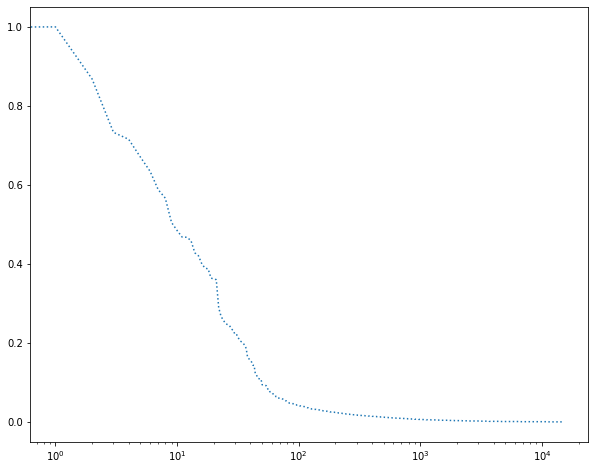

In [24]:
v1 = sorted([ebn[_] for _ in ebn], reverse=True)
v2 = [0]*1 + v1

print('Minimum degree: {}'.format(min(ebn.values())))
print('Maximum degree: {}'.format(max(ebn.values())))

v1 = np.array(v1)
v2 = np.array(v2)

avg = np.average(v1)
print('Average degree: {:.2f}'.format(avg))
sumdeg = np.sum(v1)
print('Total rid edges: {}'.format(sumdeg))

norm_v1 = normalize(v2)
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
# plt.loglog(v1)

plt.semilogx(norm_v1, label='normalized frequencies', ls=':')



In [27]:
total_nodes = len(v1)
print('Total nodes: {}'.format(total_nodes))
avg = np.average(v1)
print('Average degree: {:.2f}'.format(avg))
sumdeg = np.sum(v1)
print('Total rid edges: {}'.format(sumdeg))
maxdeg = max(v1)
print('Max degree: {}'.format(maxdeg))
perc = np.percentile(v1, 99)
print('99-th percentile: {:.2f}'.format(perc))
print('99-th perc/n edges: {:.4f}%'.format(perc/sumdeg*100))
aboveperc = v1[v1>perc]
print('Nodes above 99-th perc: {}'.format(len(aboveperc)))
edgesaboveperc = sum(aboveperc)
print('Edges above 99th perc: {}'.format(edgesaboveperc))
print('Frac above perc: {:.2f}'.format(edgesaboveperc/sumdeg*100))
avg_deg_above_perc = np.average(aboveperc)
print('Average degree above perc: {:.2f}'.format(avg_deg_above_perc))


Total nodes: 14814
Average degree: 8.72
Total rid edges: 129251
Max degree: 2212
99-th percentile: 67.87
99-th perc/n edges: 0.0525%
Nodes above 99-th perc: 149
Edges above 99th perc: 47336
Frac above perc: 36.62
Average degree above perc: 317.69


In [3]:
def smooth_freq(freq, s=0.2, k=0.05, target=200, eps=0.01):
    return smooth_exp(freq, eps, target, k, s)

def smooth_exp(x, eps, target, k, s):
    t = (eps/(1-s))**(k/(1-target))
    y = (1-s) * t ** (-1/k*x + 1/k) + s    
    return y

def f_log(x, b=10):
    log_b = np.log10(x) / np.log10(b)
    return 1/(log_b+1)

def smooth_exp_v2(x, target, s):
    b = (1/2) ** (1/(1-target))
    y = (1-s) * b ** (-1*x + 1) + s
    return y

def smooth_freq_v2(freq, s=0.2, target=200):
    return smooth_exp_v2(freq,target,s)

def inverse(x):
    return 1/x

def inverse_smooth(x, s):
    y = (1/2) * ((s-1) * math.e ** (1-x) + 2 - s)
    return y

In [39]:
g = nx.Graph()

Average degree: 4.03
Total rid edges: 432048
0 32185
Skewness: 166.22
Kurtosis: 32983.98


/home/spoutnik23/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


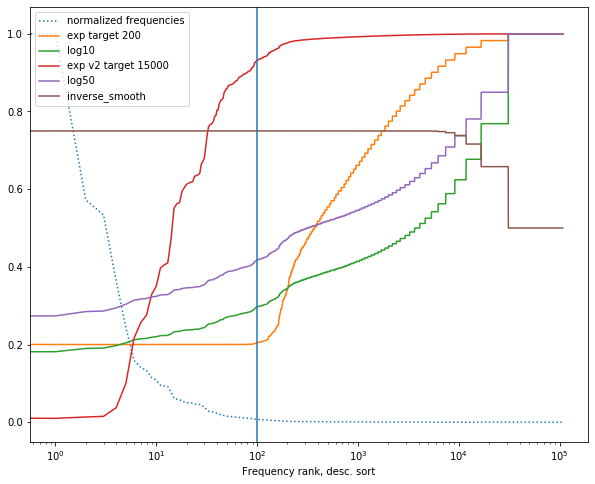

<Figure size 720x432 with 0 Axes>

In [16]:
path_df = str('../pipeline/datasets/movies-aligned-master.csv')
df = pd.read_csv(path_df, dtype=str)

counts = Counter(df.values.ravel())
if np.nan in counts:
    counts.pop(np.nan)

len(counts)

v = counts.most_common()

v1 = [_[1] for _ in v]
v1 = [0]*1 + v1

v1 = np.array(v1)
vmovies = v1

avg = np.average(v1)
print('Average degree: {:.2f}'.format(avg))
sumdeg = np.sum(v1)
print('Total rid edges: {}'.format(sumdeg))

norm_v1 = normalize(v1)
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
# plt.loglog(v1)

plt.semilogx(norm_v1, label='normalized frequencies', ls=':')

# plt.xlim([0, 1000])
# fig = plt.figure()
y1 = smooth_freq(v1)
y2 = f_log(v1)
y3 = smooth_freq(v1, target=15000, s=0.01)
y4 = f_log(v1, 50)
y5 = inverse_smooth(v1, 0.5)

plt.semilogx(y1, label='exp target 200')
plt.semilogx(y2, label='log10')
plt.semilogx(y3, label='exp v2 target 15000')
plt.semilogx(y4, label='log50')
plt.semilogx(y5, label='inverse_smooth')

plt.xlabel('Frequency rank, desc. sort')
plt.legend()
ax.axvline(100)
# plt.xlim([0.1,10e5])
fig = plt.figure(figsize=(10,6))
print('Skewness: {:.2f}'.format(stats.skew(v1)))
print('Kurtosis: {:.2f}'.format(stats.kurtosis(v1)))

In [ ]:
fig = plt.figure(figsize=(10,6))

plt.semilogx(y1*v1, label='exp target 200')
plt.semilogx(y2*v1, label='log10')
plt.semilogx(y3*v1, label='exp v2 target 10')
plt.semilogx(y4*v1, label='log5')
plt.semilogx(v1, label='unweighted')
plt.legend()

In [ ]:
plt.semilogx(normalize(vmovies), label='movies')
plt.semilogx(normalize(vanime), label='anime')
plt.semilogx(normalize(vdblp), label='dblp')
plt.legend()

In [222]:
stats.cumfreq(v1)

CumfreqResult(cumcount=array([11481., 11493., 11495., 11495., 11496., 11503., 11507., 11508.,
       11510., 11511.]), lowerlimit=-48.72222222222222, binsize=97.44444444444443, extrapoints=0)

In [22]:
xax = np.linspace(99.5,100, num=10)
perc = np.percentile(v1, xax)

(90, 100)

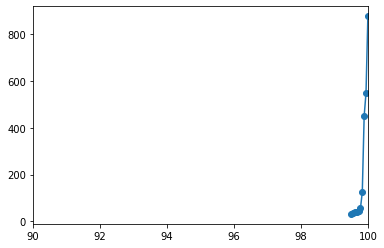

In [24]:
plt.plot(xax,perc, marker='o')
plt.xlim([90, 100])

In [33]:
dsets = [
    str('../pipeline/datasets/movies-aligned-master.csv'),
    str('../pipeline/datasets/anime-master.csv'),
    str('../pipeline/datasets/dblp-master.csv'),
    str('../pipeline/datasets/corleone-master.csv'),
    str('../pipeline/datasets/bikes-master.csv'),
    
]

names = [os.path.basename(ds) for ds in dsets]

counts_list = []

for ds in dsets:
    df = pd.read_csv(ds, dtype=str)

    counts = Counter(df.values.ravel())
    if np.nan in counts:
        counts.pop(np.nan)

    len(counts)

    v = counts.most_common()

    v1 = [_[1] for _ in v]
    v1 = [0]*1 + v1

    v1 = np.array(v1)
    counts_list.append(v1)
    
    print('Dataset: {}'.format(ds))
    total_nodes = len(v1)
    total_nodes_with_rids = len(v1) + len(df)
    print('Total nodes: {}'.format(total_nodes))
    print('Total nodes with rids: {}'.format(total_nodes_with_rids))
    avg = np.average(v1)
    print('Average degree: {:.2f}'.format(avg))
    sumdeg = np.sum(v1)
    print('Total rid edges: {}'.format(sumdeg))
    maxdeg = max(v1)
    print('Max degree: {}'.format(maxdeg))
    perc = np.percentile(v1, 95)
    print('99-th percentile: {}'.format(perc))
    print('99-th perc/n edges: {:.6f}%'.format(perc/sumdeg*100))
    aboveperc = v1[v1>perc]
    print('Nodes above 99-th perc: {}'.format(len(aboveperc)))
    edgesaboveperc = sum(aboveperc)
    print('Edges above 99th perc: {}'.format(edgesaboveperc))
    print('Frac above perc: {:.2f}'.format(edgesaboveperc/sumdeg*100))
    avg_deg_above_perc = np.average(aboveperc)
    print('Average degree above perc: {:.2f}'.format(avg_deg_above_perc))
    
    print('')

Dataset: ../pipeline/datasets/movies-aligned-master.csv
Total nodes: 107261
Total nodes with rids: 157136
Average degree: 4.03
Total rid edges: 432048
Max degree: 32185
99-th percentile: 7.0
99-th perc/n edges: 0.001620%
Nodes above 99-th perc: 5348
Edges above 99th perc: 280123
Frac above perc: 64.84
Average degree above perc: 52.38

Dataset: ../pipeline/datasets/anime-master.csv
Total nodes: 7246
Total nodes with rids: 15246
Average degree: 10.58
Total rid edges: 76650
Max degree: 4213
99-th percentile: 10.0
99-th perc/n edges: 0.013046%
Nodes above 99-th perc: 354
Edges above 99th perc: 67271
Frac above perc: 87.76
Average degree above perc: 190.03

Dataset: ../pipeline/datasets/dblp-master.csv
Total nodes: 11511
Total nodes with rids: 16421
Average degree: 2.81
Total rid edges: 32319
Max degree: 877
99-th percentile: 5.0
99-th perc/n edges: 0.015471%
Nodes above 99-th perc: 492
Edges above 99th perc: 16221
Frac above perc: 50.19
Average degree above perc: 32.97

Dataset: ../pipelin

/home/spoutnik23/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/spoutnik23/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


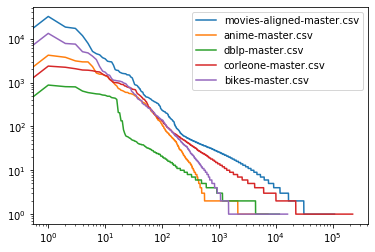

In [139]:
for l in range(len(counts_list)):
    plt.loglog(counts_list[l], label=names[l])
plt.legend()

In [3]:
dname = 'dblp_acm'
fpath = 'pipeline/walks/{}-el-baserot.walks'.format(dname)

In [7]:
from collections import Counter
import pandas as pd

In [8]:
c = Counter()

with open(fpath, 'r') as fp:
    for idx, line in enumerate(fp):
        c.update(line.strip().split(' '))

In [9]:
c.most_common(n=10)

[('cid__title', 546069),
 ('cid__author_1', 406314),
 ('cid__author_2', 366900),
 ('cid__author_3', 294239),
 ('cid__author_4', 188920),
 ('tt__data', 160612),
 ('tt__sigmod', 140113),
 ('tt__conference', 118014),
 ('tt__of', 115731),
 ('tt__on', 107704)]

In [11]:
dd = pd.DataFrame(c.most_common())

dd.columns = ['value', 'frequency']

In [17]:
def p(val, t=0.001):
    return (val-t)/val - (t/val)**(1/2)

def sample(val, t=0.001):
    return val-((val-t)/val - (t/val)**(1/2))*val

In [20]:
dd['p'] = dd['frequency'].apply(p, t=0.1)

dd['sampled'] = dd['frequency'].apply(sample, t=0.1)

dd

,value,frequency,p,sampled
0,cid__title,546069,0.999572,233.781193
1,cid__author_1,406314,0.999504,201.672320
2,cid__author_2,366900,0.999478,191.646339
3,cid__author_3,294239,0.999417,171.633962
4,cid__author_4,188920,0.999272,137.548172
...,...,...,...,...
19725,tt__efficient_and_tumble_similar_set_retrieval,139,0.972458,3.828270
19726,tt__bradford_pielech,136,0.972148,3.787818
19727,tt__orderofmagnitude_advantage_on_tpcc_through...,134,0.971936,3.760601
19728,tt__kevin_haas,133,0.971828,3.746917


In [21]:
dd['p'] = dd['frequency'].apply(p, t=0.001)

dd['sampled'] = dd['frequency'].apply(sample, t=0.001)

dd

,value,frequency,p,sampled
0,cid__title,546069,0.999957,23.369119
1,cid__author_1,406314,0.999950,20.158232
2,cid__author_2,366900,0.999948,19.155634
3,cid__author_3,294239,0.999942,17.154396
4,cid__author_4,188920,0.999927,13.745817
...,...,...,...,...
19725,tt__efficient_and_tumble_similar_set_retrieval,139,0.997311,0.373827
19726,tt__bradford_pielech,136,0.997281,0.369782
19727,tt__orderofmagnitude_advantage_on_tpcc_through...,134,0.997261,0.367060
19728,tt__kevin_haas,133,0.997250,0.365692
